# Fitting NorESM2 out-of-the-box

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [4]:
files = os.listdir(case_dir)
files.sort()
files

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

In [4]:
node_met =CT_SLF_Metric(case_dir)

node_met.add_case("20200204_113441_singleparam_inpcheck_wbf_1_inp_10")
node_met.add_case('20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10')

Trying to load concatenated file for 20200204_113441_singleparam_inpcheck_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200512_013308_fitting_runs_cam6paramtest16_wbf_1.4_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


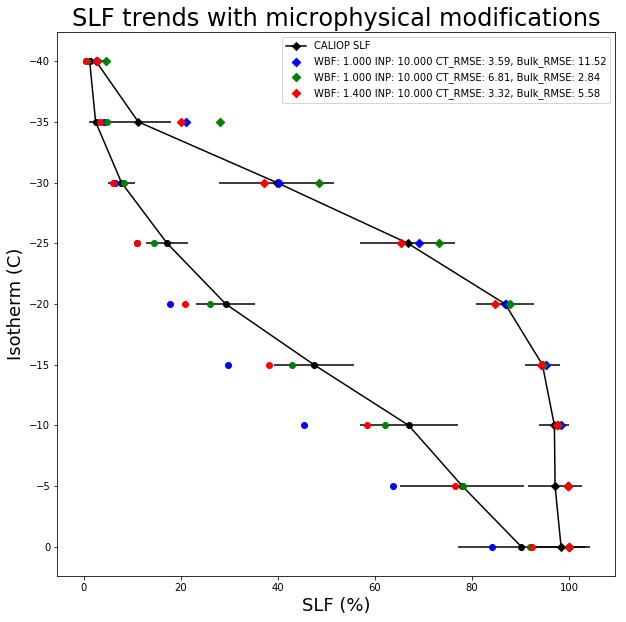

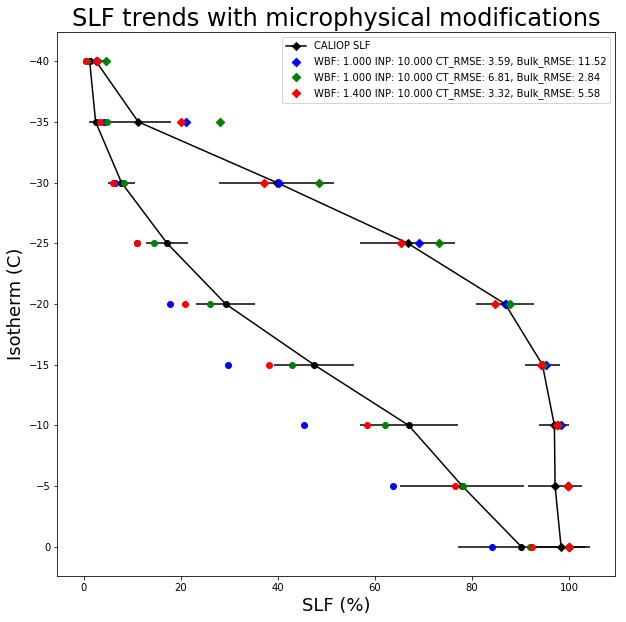

In [5]:
node_met.plot_isos_all()

In [4]:
other_met = CT_SLF_Metric(case_dir)
other_met.add_case('20200109_1541_wbf_1.0_inp_1.0')
other_met.add_case('20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10')
# other_met.add_case('20200502_215951_singleparam_cam6paramtest_wbf_0.1_inp_10')
# other_met.add_case('20200502_215951_singleparam_cam6paramtest_wbf_0.5_inp_10')
# other_met.add_case('20200504_145438_fitting_runs_cam6paramtest_wbf_1.0_inp_20')
# other_met.add_case('20200504_145438_fitting_runs_cam6paramtest_wbf_2.0_inp_10')
other_met.add_case("20200505_171838_fitting_runs_cam6paramtest_wbf_1.5_inp_10")
other_met.add_case("20200506_morning_fitting_runs_cam6paramtest_wbf_1.4_inp_10")
other_met.add_case("20200512_013308_fitting_runs_cam6paramtest16_wbf_1.4_inp_10")
other_met.add_case("20200512_013308_fitting_runs_cam6paramtest16_wbf_1.25_inp_10")

Trying to load concatenated file for 20200109_1541_wbf_1.0_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200505_171838_fitting_runs_cam6paramtest_wbf_1.5_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200506_morning_fitting_runs_cam6paramtest_wbf_1.4_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200512_013308_fitting_runs_cam6paramtest16_wbf_1.4_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200512_013308_fitting_runs_cam6paramtest16_wbf_1.25_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


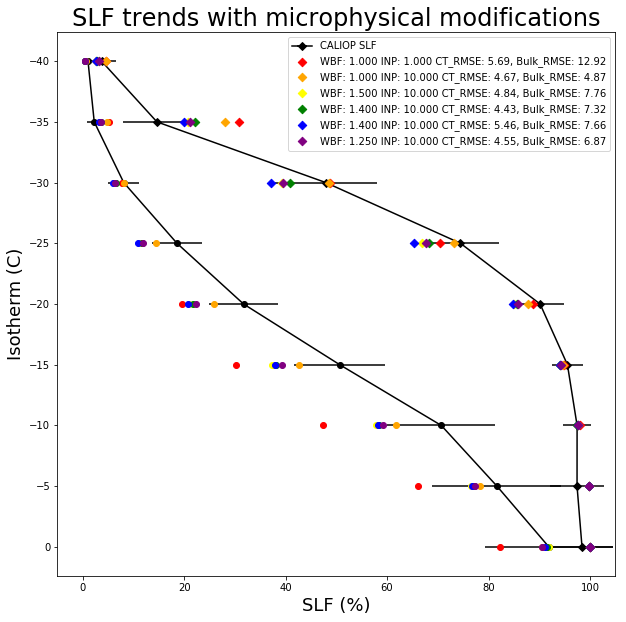

In [5]:
p = other_met.plot_isos_all()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


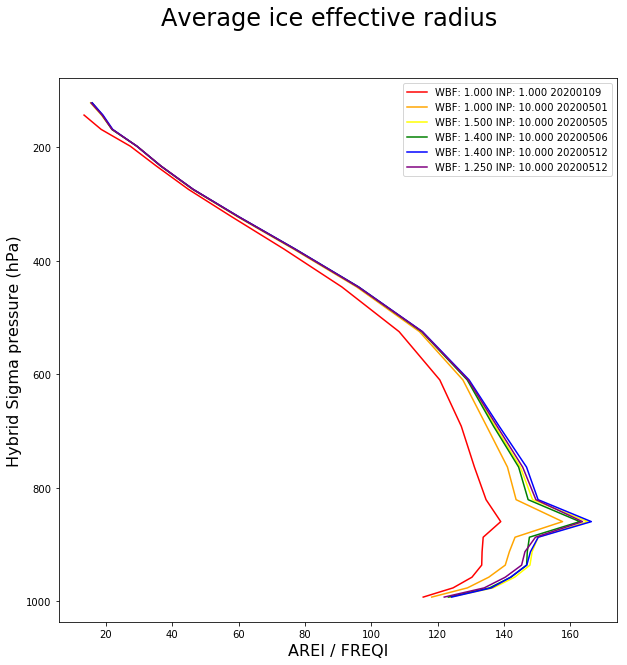

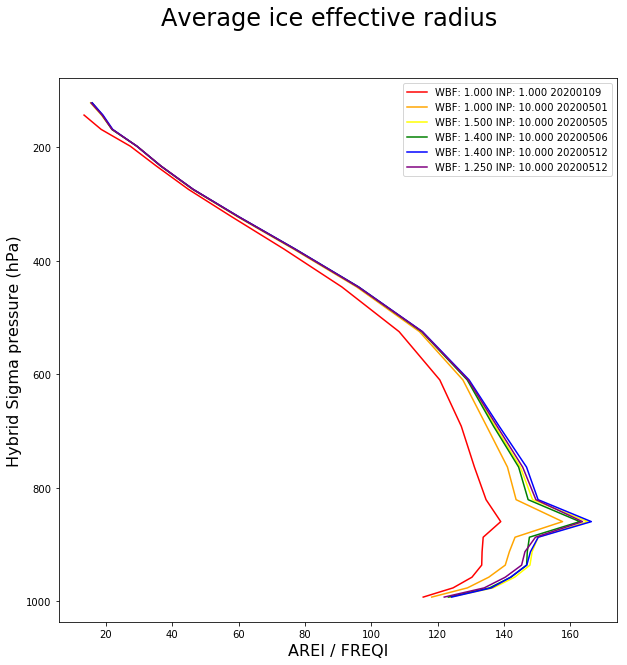

In [6]:
other_met.plot_var_ratio('AREI','FREQI')

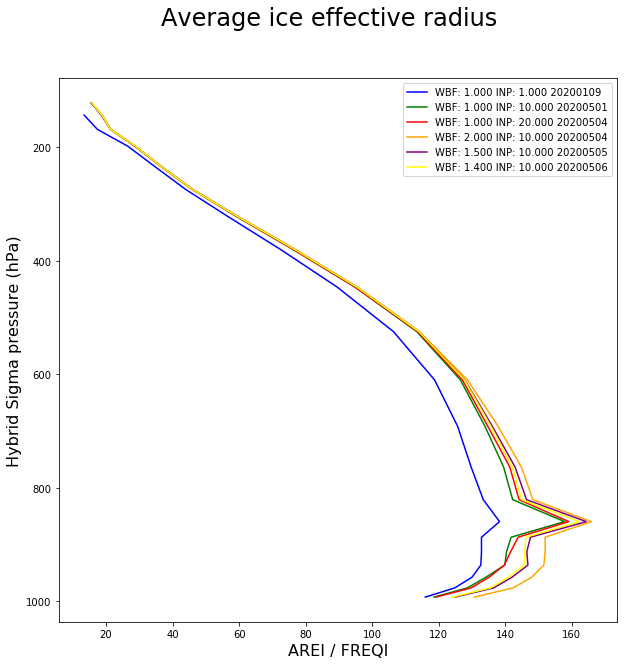

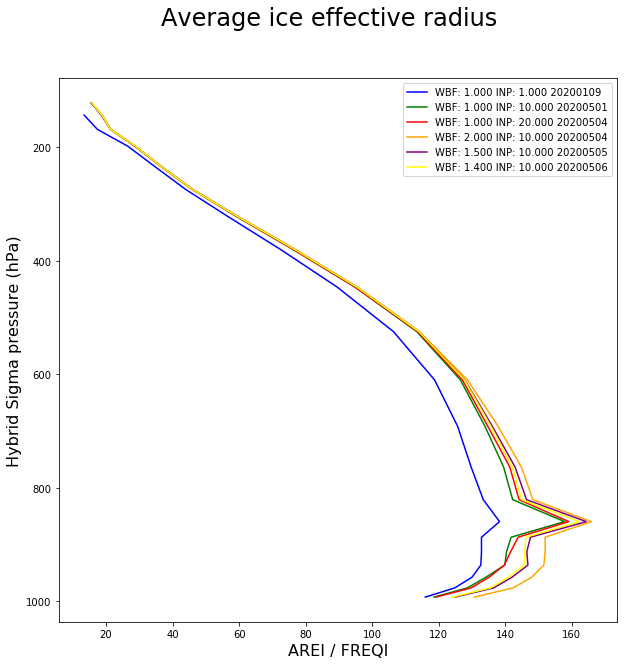

In [7]:
other_met.plot_var_ratio("AREI","FREQI")

In [8]:
origin_case = '20200109_1541_wbf_1.0_inp_1.0'

mainmetric = CT_SLF_Metric(case_dir)
mainmetric.add_case(origin_case)
mainmetric.add_case('20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100')
mainmetric.add_case('20200116_130416_nudged_wbfmods_wbf_0.01_inp_1')
#mainmetric.add_case('20200116_130416_nudged_wbfmods_wbf_10_inp_1')
#mainmetric.add_case('20200110_142006_singleparam_nudge_wbf_1_inp_1000')
mainmetric.add_case('20200327_170021_singleparam_noresm2tests_wbf_0.05_inp_1')
mainmetric.add_case('20200327_170021_singleparam_noresm2tests_wbf_1_inp_10')
mainmetric.add_case('20200327_170021_singleparam_noresm2tests_wbf_0.1_inp_1')
mainmetric.add_case('20200405_142306_singleparam_noresm2tests_wbf_0.005_inp_1')
mainmetric.add_case('20200405_142306_singleparam_noresm2tests_wbf_0.01_inp_0.5')

# mainmetric.add_case('20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10')

mainmetric.set_origin(origin_case)

Trying to load concatenated file for 20200109_1541_wbf_1.0_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200323_170403_singleparam_cam6_fit_wbf_0.3_inp_100


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200116_130416_nudged_wbfmods_wbf_0.01_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_170021_singleparam_noresm2tests_wbf_0.05_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_170021_singleparam_noresm2tests_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_170021_singleparam_noresm2tests_wbf_0.1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_142306_singleparam_noresm2tests_wbf_0.005_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_142306_singleparam_noresm2tests_wbf_0.01_inp_0.5


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200501_184452_singleparam_cam6paramtest_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


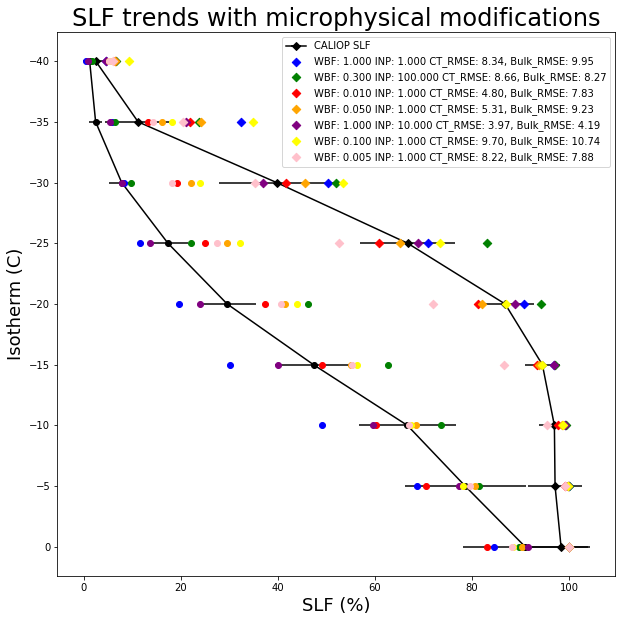

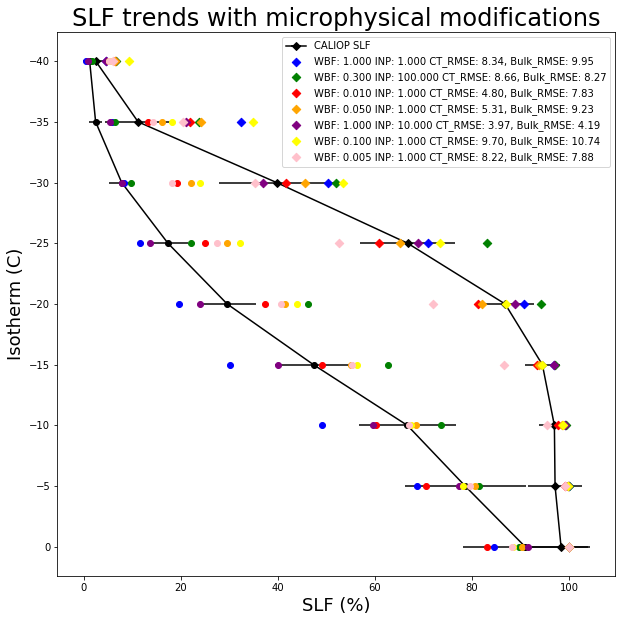

In [9]:
mainmetric.plot_isos_all()

-7.071905572862473 5.709248712595407
5.756680473296183 6.9417237769285345
2.3037659391182883 0.9275378272460046
7.460972380183725 2.391508938335584
-2.392952406499766 2.4989599551903803
7.968176347885978 6.3053906318633315


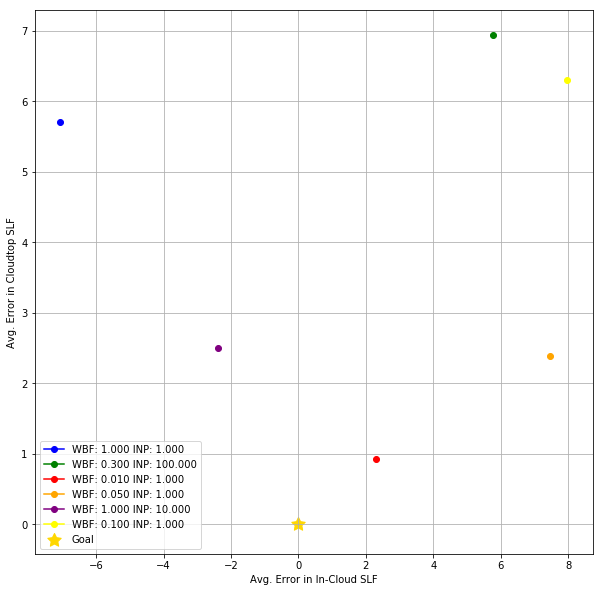

In [12]:
mainmetric.dual_parameterspace()

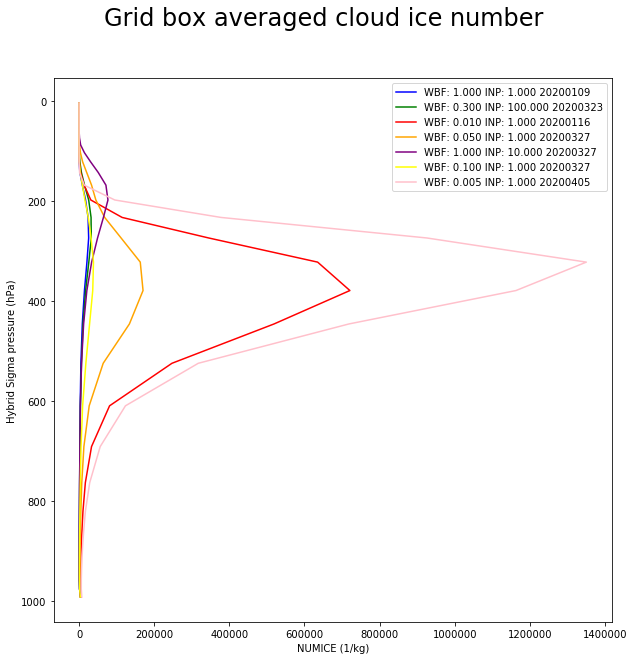

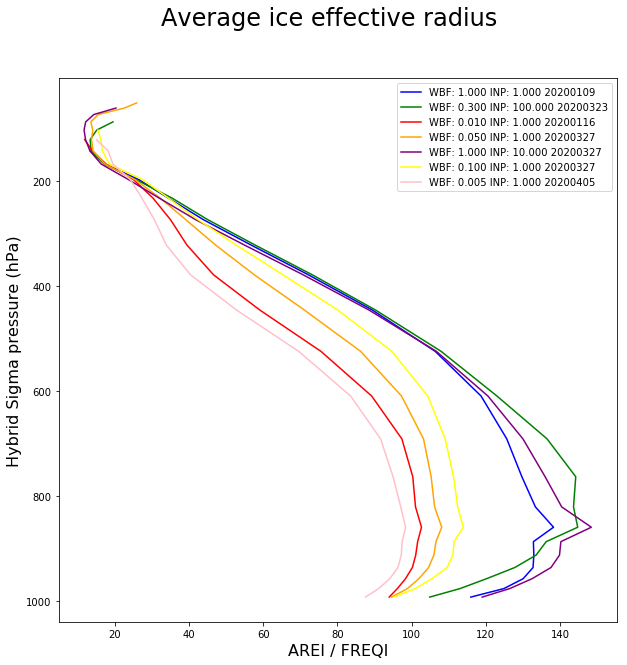

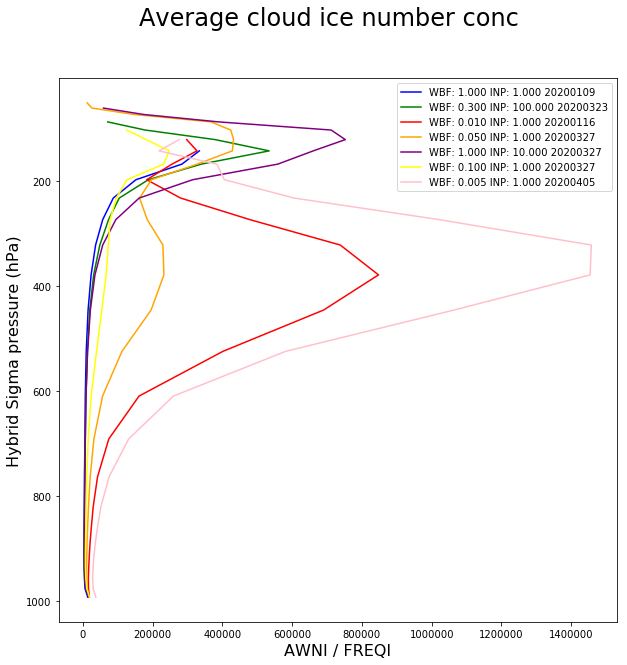

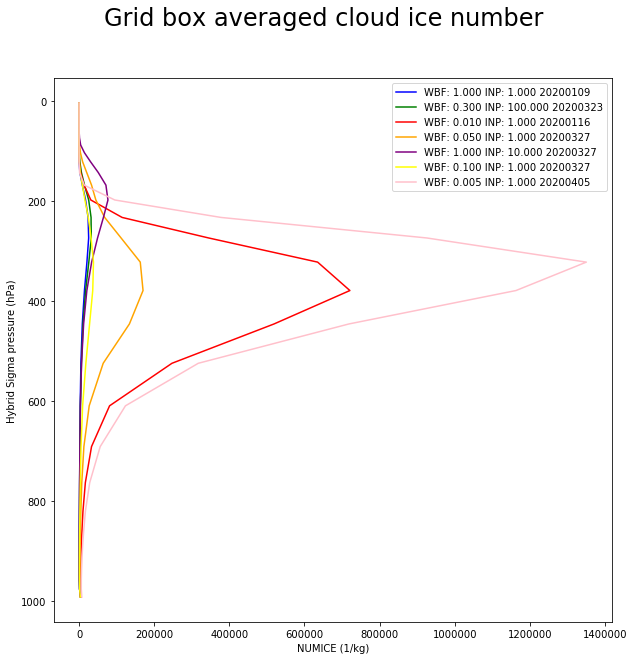

In [6]:
mainmetric.plot_var_ratio('AREI','FREQI')
mainmetric.plot_var_ratio('AWNI','FREQI')
mainmetric.plot_single_var('NUMICE')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


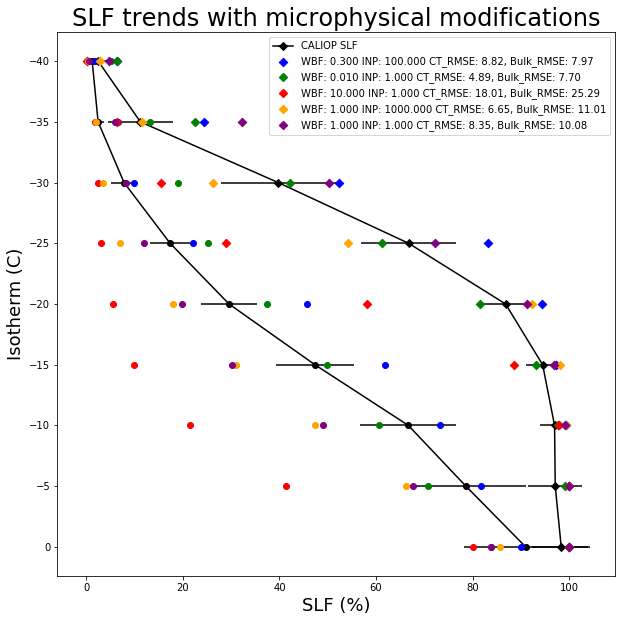

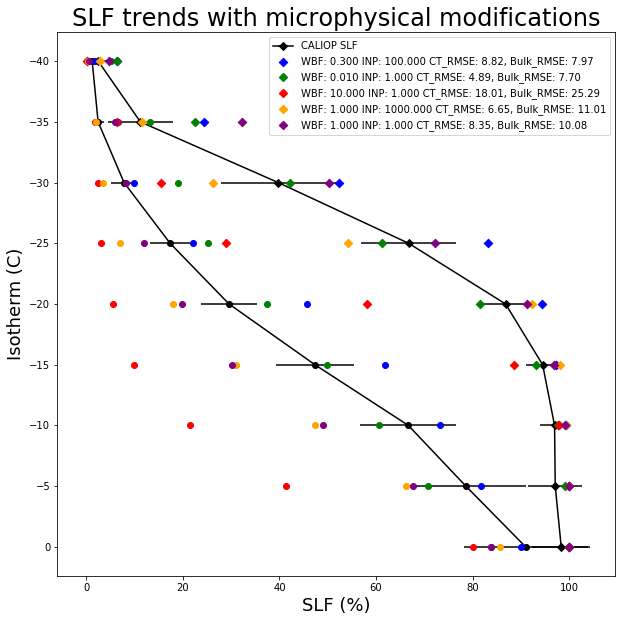

In [12]:
mainmetric.plot_isos_all()

This is fucking confusing, but it seems that I should be able to get things to agree with enough tinkering. I am submitting 3 more runs to try and understand things.